In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
pd.options.display.max_rows = 500

In [3]:
import os
import sys

releasy_module = os.path.abspath(os.path.join('..','..','..','dev','releasy2'))
if releasy_module not in sys.path:
    sys.path.insert(0, releasy_module)
    
import releasy
from releasy.miner_git import GitVcs
from releasy.miner import TagReleaseMiner, PathCommitMiner, RangeCommitMiner, TimeCommitMiner, VersionReleaseMatcher, VersionReleaseSorter, TimeReleaseSorter


In [4]:
projects = pd.read_pickle('projects.zip')

In [6]:
releases = pd.DataFrame(columns=[
    "project","name", "lang","commits",
    "range_commits", "range_tpos", "range_fpos","range_fneg",
    "time_commits", "time_tpos", "time_fpos","time_fneg"])
    
count = 0
for i,project in enumerate(projects.itertuples()):
    path = os.path.abspath(os.path.join('..','..','..','repos2',project.name))
    
    try:
        print(f"{i+1:3} {project.name}")
        vcs = GitVcs(path)
        release_matcher = VersionReleaseMatcher()
        time_release_sorter = TimeReleaseSorter()
        version_release_sorter = VersionReleaseSorter()

        time_release_miner = TagReleaseMiner(vcs, release_matcher, time_release_sorter)
        time_release_set = time_release_miner.mine_releases()

        
        version_release_miner = TagReleaseMiner(vcs, release_matcher, version_release_sorter)
        version_release_set = version_release_miner.mine_releases()

        path_miner = PathCommitMiner(vcs, time_release_set)
        range_miner = RangeCommitMiner(vcs, version_release_set)
        time_miner = TimeCommitMiner(vcs, version_release_set)
    
        print(f" - parsing by path")
        path_release_set = path_miner.mine_commits()
        print(f" - parsing by time")
        time_release_set = time_miner.mine_commits()
        print(f" - parsing by range")
        range_release_set = range_miner.mine_commits()
        
    
        stats = []
        for release in version_release_set:
            path_commits = set(path_release_set[release.name].commits)
            range_commits = set(range_release_set[release.name].commits)
            time_commits = set(time_release_set[release.name].commits)
    
            stats.append({
                "project": project.name,
                "name": release.name,
                "lang": project.lang,
                "commits": len(path_commits),
                "range_commits": len(range_commits),
                "range_tpos": len(path_commits & range_commits),
                "range_fpos": len(range_commits - path_commits),
                "range_fneg": len(path_commits - range_commits),
                "time_commits": len(time_commits),
                "time_tpos": len(path_commits & time_commits),
                "time_fpos": len(time_commits - path_commits),
                "time_fneg": len(path_commits - time_commits)
            })
        releases = releases.append(pd.DataFrame(stats))
    except Exception as e:
        print(f" - error: {e}")
    
releases_bkp = releases.copy()  

  1 vuejs/vue
 - parsing by path
 - parsing by time
 - parsing by range
  2 facebook/react
 - parsing by path
 - parsing by time
 - parsing by range
  3 twbs/bootstrap
 - parsing by path
 - parsing by time
 - parsing by range
  4 d3/d3
 - parsing by path
 - parsing by time
 - parsing by range
  5 facebook/react-native
 - parsing by path
 - parsing by time
 - parsing by range
  6 facebook/create-react-app
 - parsing by path
 - parsing by time
 - parsing by range
  7 nodejs/node
 - parsing by path
 - parsing by time
 - parsing by range
  8 mrdoob/three.js
 - parsing by path
 - parsing by time
 - parsing by range
  9 mui-org/material-ui
 - parsing by path
 - parsing by time
 - parsing by range
 10 angular/angular.js
 - parsing by path
 - parsing by time
 - parsing by range
 11 microsoft/vscode
 - parsing by path
 - parsing by time
 - parsing by range
 12 denoland/deno
 - parsing by path
 - parsing by time
 - parsing by range
 13 angular/angular
 - parsing by path
 - parsing by time
 - par

In [7]:
# releases_bkp = releases.copy()
# releases = releases_bkp.copy()

In [8]:
releases = releases[releases.commits > 0].copy()

In [9]:
releases.commits = pd.to_numeric(releases.commits)
releases.range_commits = pd.to_numeric(releases.range_commits)
releases.range_tpos = pd.to_numeric(releases.range_tpos)
releases.range_fpos = pd.to_numeric(releases.range_fpos)
releases.range_fneg = pd.to_numeric(releases.range_fneg)
releases.time_commits = pd.to_numeric(releases.time_commits)
releases.time_tpos = pd.to_numeric(releases.time_tpos)
releases.time_fpos = pd.to_numeric(releases.time_fpos)
releases.time_fneg = pd.to_numeric(releases.time_fneg)

In [10]:
def precision(row, column):
    if row[column+"_tpos"] + row[column+"_fpos"] == 0:
        return 0.0
    else:
        return row[column+"_tpos"] / (row[column+"_tpos"] + row[column+"_fpos"])
    
def recall(row, column):
    if row[column+"_tpos"] + row[column+"_fneg"] == 0:
        return 0.0
    else:
        return row[column+"_tpos"] / (row[column+"_tpos"] + row[column+"_fneg"])


In [11]:
releases['range_precision'] = releases.apply(precision, args=('range',), axis=1)
releases['range_recall'] = releases.apply(recall, args=('range',), axis=1)
releases['time_precision'] = releases.apply(precision, args=('time',), axis=1)
releases['time_recall'] = releases.apply(recall, args=('time',), axis=1)

In [12]:
releases[releases['range_precision'] > 0.5].shape[0]

19050

In [13]:
releases[releases['time_recall'] < 1].shape

(6414, 16)

In [14]:
debug = False

p    rng  tme 


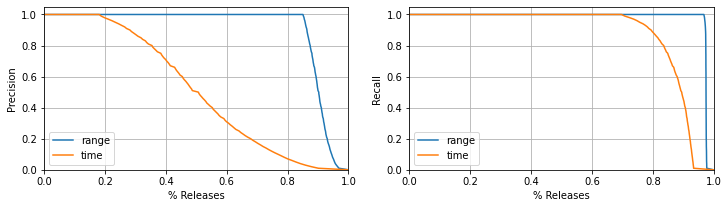

In [15]:
fig, (ap,ar) = plt.subplots(1,2)
fig.set_size_inches(12,3)
ap.set_xlabel("% Releases")
ap.set_ylabel("Precision")

ar.set_xlabel("% Releases")
ar.set_ylabel("Recall")

total = releases.shape[0]
increments = 0.01
y = []
x_precision_range = []
x_precision_time = []
x_recall_range = []
x_recall_time = []
print(f'{"p":4} {"rng":4} {"tme":4}')
for rng in np.arange(0, 1+increments, increments):
    range_precision_percent = releases[releases['range_precision'] >= rng].shape[0] / total 
    time_precision_percent = releases[releases['time_precision'] >= rng].shape[0] / total 
    range_recall_percent = releases[releases['range_recall'] >= rng].shape[0] / total 
    time_recall_percent = releases[releases['time_recall'] >= rng].shape[0] / total 
    x_precision_range.append(range_precision_percent)
    x_precision_time.append(time_precision_percent)
    x_recall_range.append(range_recall_percent)
    x_recall_time.append(time_recall_percent)
    
    y.append(rng)
    print(f"{y[-1]:4.2f} {x_precision_range[-1]:4.2f} {x_precision_time[-1]:4.2f} {x_recall_range[-1]:4.2f} {x_recall_time[-1]:4.2f}") if debug else None

y.append(1)
x_precision_range.append(0)
x_precision_time.append(0)
x_recall_range.append(0)
x_recall_time.append(0)
ap.plot(x_precision_range,y, label='range')
ap.plot(x_precision_time,y, label='time')
ap.legend(loc='lower left')
ap.set_xlim((0,1))
ap.set_ylim((0,1.05))
ap.xaxis.grid()
ap.yaxis.grid()

ar.plot(x_recall_range,y, label='range')
ar.plot(x_recall_time,y, label='time')
ar.legend(loc='lower left')
ar.set_xlim((0,1))
ar.set_ylim((0,1.05))
ar.xaxis.grid(which='both')
ar.yaxis.grid()

In [22]:
releases[(releases.commits < 20) & (releases.range_recall > 0) & (releases.range_recall < 1)][['project','name','commits','range_commits','time_commits','range_precision', 'range_recall', 'time_precision', 'time_recall']]

,project,name,commits,range_commits,time_commits,range_precision,range_recall,time_precision,time_recall
228,d3/d3,v5.0.0-rc.1,5,3,0,1.0,0.600000,0.0,0.0
162,angular/angular.js,v1.5.0-beta.0,8,1,0,1.0,0.125000,0.0,0.0
372,storybookjs/storybook,v4.2.0-cra-debug.0,19,2,0,1.0,0.105263,0.0,0.0
639,storybookjs/storybook,v5.3.0-apanizo,3,1,0,1.0,0.333333,0.0,0.0
8,google/guava,v5.0,7,3,0,1.0,0.428571,0.0,0.0
59,sebastianbergmann/phpunit,3.0.0rc1,7,1,0,1.0,0.142857,0.0,0.0
16,tesseract-ocr/tesseract,3.05.00dev,19,1,0,1.0,0.052632,0.0,0.0
51,redis/redis,2.2.105-scripting,4,3,0,1.0,0.750000,0.0,0.0
47,libuv/libuv,node-v0.8.1,19,12,0,1.0,0.631579,0.0,0.0
18,heartcombo/devise,v1.1.pre,17,15,0,1.0,0.882353,0.0,0.0


In [17]:
releases[(releases.commits < 20) & (releases.range_precision > 0.5) & (releases.range_precision < 1) & (releases.time_precision > 0.4) & (releases.time_precision < 1) & (releases.range_commits != releases.time_commits) & (releases.time_recall < 1)][['project','name','commits','range_commits','time_commits','range_precision', 'range_recall', 'time_precision', 'time_recall']]

,project,name,commits,range_commits,time_commits,range_precision,range_recall,time_precision,time_recall
277,git/git,v1.6.4,16,19,13,0.842105,1.0,0.615385,0.500000
347,git/git,v1.7.4-rc1,15,18,23,0.833333,1.0,0.478261,0.733333
126,libuv/libuv,v0.11.6,15,23,17,0.652174,1.0,0.823529,0.933333
19,gohugoio/hugo,v0.20.5,12,23,8,0.521739,1.0,0.875000,0.583333


In [18]:
releases.shape

(21165, 16)

In [19]:
releases[releases.range_recall < 1].sort_values('range_recall', ascending=False).shape

(683, 16)

In [20]:
releases[releases.range_recall < 1]

,project,name,lang,commits,range_commits,range_tpos,range_fpos,range_fneg,time_commits,time_tpos,time_fpos,time_fneg,range_precision,range_recall,time_precision,time_recall
48,vuejs/vue,0.12.0-rc,javascript,15,0,0,0,15,0,0,0,15,0.0,0.0,0.0,0.0
54,vuejs/vue,0.12.1,javascript,13,0,0,0,13,0,0,0,13,0.0,0.0,0.0,0.0
60,vuejs/vue,0.12.6,javascript,11,0,0,0,11,0,0,0,11,0.0,0.0,0.0,0.0
62,vuejs/vue,0.12.7,javascript,7,0,0,0,7,0,0,0,7,0.0,0.0,0.0,0.0
64,vuejs/vue,0.12.8,javascript,32,0,0,0,32,0,0,0,32,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,ethereum/go-ethereum,v0.9.23,go,84,0,0,0,84,0,0,0,84,0.0,0.0,0.0,0.0
45,ethereum/go-ethereum,v0.9.34,go,88,0,0,0,88,0,0,0,88,0.0,0.0,0.0,0.0
49,ethereum/go-ethereum,poc1,go,162,0,0,0,162,0,0,0,162,0.0,0.0,0.0,0.0
162,ethereum/go-ethereum,2,go,5,0,0,0,5,0,0,0,5,0.0,0.0,0.0,0.0


In [20]:
releases.sort_values('range_recall', ascending=False)

,project,name,lang,commits,range_commits,range_tpos,range_fpos,range_fneg,time_commits,time_tpos,time_fpos,time_fneg,range_precision,range_recall,time_precision,time_recall
0,vuejs/vue,0.6.0,javascript,354,354,354,0,0,354,354,0,0,1.0,1.0,1.000000,1.000000
69,PowerShell/PowerShell,v7.0.0,c#,7,7,7,0,0,17,7,10,0,1.0,1.0,0.411765,1.000000
76,PowerShell/PowerShell,v7.1.0-preview.4,c#,109,109,109,0,0,115,90,25,19,1.0,1.0,0.782609,0.825688
75,PowerShell/PowerShell,v7.1.0-preview.3,c#,46,46,46,0,0,74,44,30,2,1.0,1.0,0.594595,0.956522
74,PowerShell/PowerShell,v7.1.0-preview.2,c#,47,47,47,0,0,54,38,16,9,1.0,1.0,0.703704,0.808511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,moby/moby,upstream/0.1.2,go,61,0,0,0,61,0,0,0,61,0.0,0.0,0.000000,0.000000
380,syncthing/syncthing,v1.4.0-rc.1,go,27,0,0,0,27,0,0,0,27,0.0,0.0,0.000000,0.000000
383,syncthing/syncthing,v1.4.0-rc.2,go,2,0,0,0,2,0,0,0,2,0.0,0.0,0.000000,0.000000
3,moby/moby,upstream/0.1.1,go,1,0,0,0,1,0,0,0,1,0.0,0.0,0.000000,0.000000


In [21]:
# fig, (ax) = plt.subplots()
# releases.sort_values('range_precision', ascending=False).plot.bar(y='range_precision', ax=ax)


1) Ordenar as releases - ordenando por data
 - path - data
 - time - data
 - range - data / version **

In [22]:
releases[releases.range_precision <= 0.001]

,project,name,lang,commits,range_commits,range_tpos,range_fpos,range_fneg,time_commits,time_tpos,time_fpos,time_fneg,range_precision,range_recall,time_precision,time_recall
49,vuejs/vue,0.12.0-rc,javascript,15,0,0,0,15,0,0,0,15,0.0,0.0,0.0,0.0
54,vuejs/vue,0.12.1,javascript,10,0,0,0,10,0,0,0,10,0.0,0.0,0.0,0.0
60,vuejs/vue,0.12.6,javascript,11,0,0,0,11,0,0,0,11,0.0,0.0,0.0,0.0
62,vuejs/vue,0.12.7,javascript,7,0,0,0,7,0,0,0,7,0.0,0.0,0.0,0.0
64,vuejs/vue,0.12.8,javascript,32,0,0,0,32,0,0,0,32,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,ethereum/go-ethereum,v0.9.34,go,88,0,0,0,88,0,0,0,88,0.0,0.0,0.0,0.0
49,ethereum/go-ethereum,poc1,go,162,0,0,0,162,0,0,0,162,0.0,0.0,0.0,0.0
162,ethereum/go-ethereum,2,go,1,0,0,0,1,0,0,0,1,0.0,0.0,0.0,0.0
163,ethereum/go-ethereum,poc5-rc1,go,1,0,0,0,1,0,0,0,1,0.0,0.0,0.0,0.0


In [23]:
releases.iloc[51]

project               vuejs/vue
name               0.12.1-csp.1
lang                 javascript
commits                       3
range_commits                16
range_tpos                    3
range_fpos                   13
range_fneg                    0
time_commits                 33
time_tpos                     3
time_fpos                    30
time_fneg                     0
range_precision          0.1875
range_recall                  1
time_precision        0.0909091
time_recall                   1
Name: 51, dtype: object

p    rng  tme 


(0.0, 1.05)

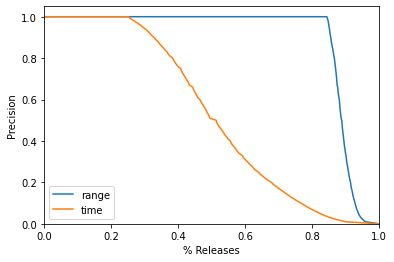

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
ax.set_xlabel("% Releases")
ax.set_ylabel("Precision")

total = releases.shape[0]
increments = 0.01
y = []
x_range = []
x_time = []
print(f'{"p":4} {"rng":4} {"tme":4}')
for rng in np.arange(0, 1+increments, increments):
    range_percent = releases[releases['range_precision'] >= rng].shape[0] / total 
    time_percent = releases[releases['time_precision'] >= rng].shape[0] / total 
    x_range.append(range_percent)
    x_time.append(time_percent)
    y.append(rng)
    print(f"{y[-1]:4.2f} {x_range[-1]:4.2f} {x_time[-1]:4.2f}") if debug else None

y.append(1)
x_range.append(0)
x_time.append(0)
ax.plot(x_range,y, label='range')
ax.plot(x_time,y, label='time')
ax.legend()
ax.set_xlim((0,1))
ax.set_ylim((0,1.05))


p    rng  tme 


(0.0, 1.05)

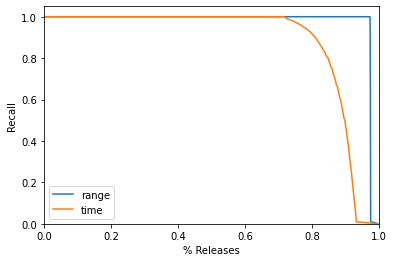

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
ax.set_xlabel("% Releases")
ax.set_ylabel("Recall")

total = releases.shape[0]
increments = 0.01
y = []
x_range = []
x_time = []
print(f'{"p":4} {"rng":4} {"tme":4}')
for rng in np.arange(0, 1+increments, increments):
    range_percent = releases[releases['range_recall'] >= rng].shape[0] / total 
    time_percent = releases[releases['time_recall'] >= rng].shape[0] / total 
    x_range.append(range_percent)
    x_time.append(time_percent)
    y.append(rng)
    print(f"{y[-1]:4.2f} {x_range[-1]:4.2f} {x_time[-1]:4.2f}") if debug else None

y.append(1)
x_range.append(0)
x_time.append(0)
ax.plot(x_range,y, label='range')
ax.plot(x_time,y, label='time')
ax.legend()
ax.set_xlim((0,1))
ax.set_ylim((0,1.05))
    


## Overall

https://stackoverflow.com/questions/43592279/difference-between-aggregate-precision-recall-curves-and-precision-recall-curves#:~:text=You%20typically%20create%20a%20precision,you%20can%20plot%20this%20curve.&text=They%20are%20referring%20to%20this,recall%20curves%20in%20this%20work.

In [26]:
overall = pd.DataFrame(releases.mean()).transpose()
overall

,commits,range_commits,range_tpos,range_fpos,range_fneg,time_commits,time_tpos,time_fpos,time_fneg,range_precision,range_recall,time_precision,time_recall
0,89.260687,161.735252,84.647531,77.087721,4.613156,212.672297,52.950716,159.721581,36.309971,0.890903,0.97473,0.527989,0.881331


,project,name,lang,commits,range_commits,range_tpos,range_fpos,range_fneg,time_commits,time_tpos,time_fpos,time_fneg,range_precision,range_recall,time_precision,time_recall
0,vuejs/vuevuejs/vuevuejs/vuevuejs/vuevuejs/vuev...,0.6.0v0.7.0v0.7.1v0.7.2v0.7.3v0.7.4v0.7.5v0.7....,javascriptjavascriptjavascriptjavascriptjavasc...,536398,2256283,536398,1719885,0,536803,344880,191923,191518,0.237735,1.0,0.64247,0.642955


## Per project

In [29]:
rproj = releases.groupby(['project']).mean()
rproj[['range_precision', 'range_recall', 'time_precision', 'time_recall']].sort_values('range_precision')

,range_precision,range_recall,time_precision,time_recall
project,,,,
dotnet/roslyn,0.247773,0.906977,0.042583,0.575001
facebook/create-react-app,0.473259,0.771739,0.323421,0.688307
google/guava,0.512747,0.946844,0.167447,0.835799
zxing/zxing,0.535379,0.948718,0.493249,0.907118
scikit-learn/scikit-learn,0.557433,0.768655,0.262148,0.664847
fastlane/fastlane,0.583473,0.863483,0.467712,0.827404
symfony/symfony,0.590270,0.986444,0.224559,0.930196
dotnet-architecture/eShopOnContainers,0.654451,0.818182,0.475870,0.686511
BVLC/caffe,0.673821,0.900000,0.651355,0.854294


## Per Language

In [36]:
rlang = releases.groupby(['lang']).mean()
rlang[['range_precision', 'range_recall', 'time_precision', 'time_recall']]

,range_precision,range_recall,time_precision,time_recall
lang,,,,
c,0.906076,0.970566,0.526287,0.914636
c#,0.750392,0.949749,0.408002,0.786566
c++,0.934747,0.978616,0.456259,0.900141
go,0.946971,0.978996,0.614858,0.876938
java,0.927929,0.991074,0.466158,0.878804
javascript,0.911344,0.964939,0.548338,0.890917
php,0.846458,0.995645,0.459041,0.910586
python,0.964216,0.985438,0.615722,0.912401
ruby,0.792988,0.947941,0.467450,0.837487


In [37]:
releases.groupby(['lang']).count().iloc[:,0]

lang
c             1137
c#             577
c++           1590
go            2345
java          1216
javascript    2341
php           2273
python        2878
ruby          2911
typescript    2921
Name: project, dtype: int64

## Per size

In [38]:
bins = pd.qcut(releases.commits, q=10)
rsize = releases.groupby([bins]).mean()
rsize[['range_precision', 'range_recall', 'time_precision', 'time_recall']]

,range_precision,range_recall,time_precision,time_recall
commits,,,,
"(0.999, 2.0]",0.770844,0.968875,0.421628,0.906403
"(2.0, 4.0]",0.883402,0.971130,0.431228,0.920192
"(4.0, 7.0]",0.883906,0.977744,0.438774,0.935059
"(7.0, 11.0]",0.896691,0.975703,0.473988,0.931614
"(11.0, 17.0]",0.899170,0.978612,0.508006,0.924865
"(17.0, 27.0]",0.911434,0.977847,0.563138,0.913414
"(27.0, 43.0]",0.912941,0.977800,0.591511,0.898505
"(43.0, 73.0]",0.916315,0.979177,0.610404,0.880366
"(73.0, 154.0]",0.924508,0.984171,0.630716,0.849706


In [39]:
releases.groupby([bins]).count().iloc[:,0]

commits
(0.999, 2.0]        2249
(2.0, 4.0]          2009
(4.0, 7.0]          2130
(7.0, 11.0]         1955
(11.0, 17.0]        1892
(17.0, 27.0]        2023
(27.0, 43.0]        1927
(43.0, 73.0]        1991
(73.0, 154.0]       1995
(154.0, 49096.0]    2018
Name: project, dtype: int64

In [40]:
bins = pd.qcut(releases.commits, q=10)
rlsize = releases.groupby(['lang',bins]).mean()
rlsize[['range_precision', 'range_recall', 'time_precision', 'time_recall']]

range_precision  range_recall  time_precision  \
lang       commits                                                           
c          (0.999, 2.0]             0.781665      0.949367        0.262527   
           (2.0, 4.0]               0.934078      0.954545        0.439055   
           (4.0, 7.0]               0.926658      0.971795        0.362269   
           (7.0, 11.0]              0.929035      0.968421        0.377840   
           (11.0, 17.0]             0.886480      0.987500        0.323650   
           (17.0, 27.0]             0.935916      0.989796        0.447576   
           (27.0, 43.0]             0.922092      0.967480        0.509519   
           (43.0, 73.0]             0.900727      0.948529        0.574926   
           (73.0, 154.0]            0.892067      0.982143        0.630171   
           (154.0, 49096.0]         0.924648      0.975183        0.760992   
c#         (0.999, 2.0]             0.307739      0.923913        0.103212   
           (2.0, 4.0]               0.562447      0.934783        0.173797   
           (4.0, 7.0]               0.688006      0.970588        0.164373   
           (7.0, 11.0]              0.779496      0.906250        0.196219   
           (11.0, 17.0]             0.857366      0.969697        0.217285   
           (17.0, 27.0]             0.790566      0.956522        0.348448   
           (27.0, 43.0]             0.898661      0.953488        0.507626   
           (43.0, 73.0]             0.923622      0.984848        0.641342   
           (73.0, 154.0]            0.917459      0.975610        0.771216   
           (154.0, 49096.0]         0.883140      0.932089        0.538487   
c++        (0.999, 2.0]             0.938561      0.988571        0.524952   
           (2.0, 4.0]               0.961456      0.985782        0.402256   
           (4.0, 7.0]               0.938424      0.992248        0.371444   
           (7.0, 11.0]              0.938842      0.984043        0.409020   
           (11.0, 17.0]             0.929085      0.976471        0.333231   
           (17.0, 27.0]             0.962145      0.991803        0.402145   
           (27.0, 43.0]             0.930908      0.987013        0.486148   
           (43.0, 73.0]             0.927136      0.988889        0.539319   
           (73.0, 154.0]            0.928771      0.984615        0.655187   
           (154.0, 49096.0]         0.883596      0.911243        0.586534   
go         (0.999, 2.0]             0.878312      0.958549        0.530965   
           (2.0, 4.0]               0.937221      0.966667        0.492464   
           (4.0, 7.0]               0.975884      0.988048        0.531172   
           (7.0, 11.0]              0.975750      1.000000        0.541030   
           (11.0, 17.0]             0.964499      0.996047        0.608259   
           (17.0, 27.0]             0.965016      0.983333        0.649694   
           (27.0, 43.0]             0.959264      0.985294        0.735747   
           (43.0, 73.0]             0.948630      0.978695        0.769778   
           (73.0, 154.0]            0.966510      0.988889        0.781185   
           (154.0, 49096.0]         0.950923      0.955564        0.691203   
java       (0.999, 2.0]             0.551262      0.956044        0.140626   
           (2.0, 4.0]               0.965612      1.000000        0.377028   
           (4.0, 7.0]               0.906831      0.961598        0.403940   
           (7.0, 11.0]              0.984484      1.000000        0.485731   
           (11.0, 17.0]             0.955703      1.000000        0.458428   
           (17.0, 27.0]             0.962020      1.000000        0.514305   
           (27.0, 43.0]             0.977482      1.000000        0.529756   
           (43.0, 73.0]             0.991765      1.000000        0.471117   
           (73.0, 154.0]            0.966180      0.998667        0.514420   
           (154.0, 49096.0]         0.927808      0

# Hypothesis test

## Shapiro

In [43]:
stats.shapiro(releases.range_precision)

c:\users\felip\.virtualenvs\experiment-diqkfhtj\lib\site-packages\scipy\stats\morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.41688406467437744, pvalue=0.0)

In [45]:
stats.shapiro(releases.range_recall)

ShapiroResult(statistic=0.1428220272064209, pvalue=0.0)

In [46]:
stats.shapiro(releases.time_precision)

ShapiroResult(statistic=0.839698076248169, pvalue=0.0)

In [47]:
stats.shapiro(releases.time_recall)

ShapiroResult(statistic=0.4707239866256714, pvalue=0.0)

## Wilcoxon

In [48]:
stats.wilcoxon(releases.range_precision, releases.time_precision)

WilcoxonResult(statistic=844759.5, pvalue=0.0)

In [49]:
stats.wilcoxon(releases.range_recall, releases.time_recall)

WilcoxonResult(statistic=0.0, pvalue=0.0)

In [50]:
hist_pr = np.ones((releases.shape[0],))


In [51]:
stats.wilcoxon(hist_pr, releases.range_precision)

WilcoxonResult(statistic=0.0, pvalue=0.0)

In [52]:
stats.wilcoxon(hist_pr, releases.range_recall)

WilcoxonResult(statistic=0.0, pvalue=4.1778890515039794e-110)

In [53]:
stats.wilcoxon(hist_pr, releases.time_precision)

WilcoxonResult(statistic=0.0, pvalue=0.0)

In [54]:
stats.wilcoxon(hist_pr, releases.time_recall)

WilcoxonResult(statistic=0.0, pvalue=0.0)

# Checks


In [55]:
releases[releases.range_recall < 1]

,project,name,lang,commits,range_commits,range_tpos,range_fpos,range_fneg,time_commits,time_tpos,time_fpos,time_fneg,range_precision,range_recall,time_precision,time_recall
49,vuejs/vue,0.12.0-rc,javascript,15,0,0,0,15,0,0,0,15,0.0,0.00,0.0,0.00
52,vuejs/vue,0.12.1-csp.2,javascript,20,17,17,0,3,3,3,0,17,1.0,0.85,1.0,0.15
54,vuejs/vue,0.12.1,javascript,10,0,0,0,10,0,0,0,10,0.0,0.00,0.0,0.00
60,vuejs/vue,0.12.6,javascript,11,0,0,0,11,0,0,0,11,0.0,0.00,0.0,0.00
62,vuejs/vue,0.12.7,javascript,7,0,0,0,7,0,0,0,7,0.0,0.00,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,ethereum/go-ethereum,v0.9.34,go,88,0,0,0,88,0,0,0,88,0.0,0.00,0.0,0.00
49,ethereum/go-ethereum,poc1,go,162,0,0,0,162,0,0,0,162,0.0,0.00,0.0,0.00
162,ethereum/go-ethereum,2,go,1,0,0,0,1,0,0,0,1,0.0,0.00,0.0,0.00
163,ethereum/go-ethereum,poc5-rc1,go,1,0,0,0,1,0,0,0,1,0.0,0.00,0.0,0.00


In [56]:
releases[releases.range_commits == 0]

,project,name,lang,commits,range_commits,range_tpos,range_fpos,range_fneg,time_commits,time_tpos,time_fpos,time_fneg,range_precision,range_recall,time_precision,time_recall
49,vuejs/vue,0.12.0-rc,javascript,15,0,0,0,15,0,0,0,15,0.0,0.0,0.0,0.0
54,vuejs/vue,0.12.1,javascript,10,0,0,0,10,0,0,0,10,0.0,0.0,0.0,0.0
60,vuejs/vue,0.12.6,javascript,11,0,0,0,11,0,0,0,11,0.0,0.0,0.0,0.0
62,vuejs/vue,0.12.7,javascript,7,0,0,0,7,0,0,0,7,0.0,0.0,0.0,0.0
64,vuejs/vue,0.12.8,javascript,32,0,0,0,32,0,0,0,32,0.0,0.0,0.0,0.0
66,vuejs/vue,0.12.9,javascript,24,0,0,0,24,0,0,0,24,0.0,0.0,0.0,0.0
68,vuejs/vue,0.12.10,javascript,29,0,0,0,29,0,0,0,29,0.0,0.0,0.0,0.0
70,vuejs/vue,0.12.11,javascript,53,0,0,0,53,0,0,0,53,0.0,0.0,0.0,0.0
72,vuejs/vue,0.12.12,javascript,2,0,0,0,2,0,0,0,2,0.0,0.0,0.0,0.0
75,vuejs/vue,0.12.14,javascript,13,0,0,0,13,0,0,0,13,0.0,0.0,0.0,0.0


In [75]:
#rlang_df.to_csv('rlang.csv')
rlang_df

,fpos,fneg,tpos,precision,recall
lang,,,,,
c,11796,133598,32696,0.734874,0.196616
c#,1946,31966,17320,0.898993,0.351418
c++,5856,110906,5332,0.476582,0.045871
go,22877,64382,37229,0.619389,0.366387
java,32884,2601684,41995,0.560838,0.015885
javascript,45753,1465681,78094,0.630568,0.050586
php,13515,752975,24884,0.648038,0.031990
python,5102,59311,21215,0.806133,0.263455
ruby,4910,295170,32312,0.868089,0.098668


In [73]:
releases_df.loc[:,['project','lang']].drop_duplicates().to_csv('p.csv')

In [57]:
rproj_df = releases_df.groupby(['project']).sum()
rproj_df['precision'] = rproj_df.apply(precision, axis=1)
rproj_df['recall'] = rproj_df.apply(recall, axis=1)

In [87]:
releases_df[(releases_df.project == 'Homebrew/brew') & (releases_df.precision < 1.0)].sort_values(['precision'], ascending=False)

,project,name,lang,path_commits,time_commits,fpos,fneg,tpos,precision,recall
151,Homebrew/brew,0.9.8,ruby,4892,4896,4,0,4892,0.999183,1.000000
163,Homebrew/brew,0.5,ruby,332,333,1,0,332,0.996997,1.000000
161,Homebrew/brew,0.7,ruby,270,271,1,0,270,0.996310,1.000000
162,Homebrew/brew,0.6,ruby,165,165,1,1,164,0.993939,0.993939
69,Homebrew/brew,1.7.2,ruby,327,312,2,17,310,0.993590,0.948012
...,...,...,...,...,...,...,...,...,...,...
134,Homebrew/brew,1.1.5,ruby,2295,3,1,2293,2,0.666667,0.000871
96,Homebrew/brew,1.5.8,ruby,5,3,1,3,2,0.666667,0.400000
8,Homebrew/brew,2.4.1,ruby,1626,128,45,1543,83,0.648438,0.051046
4,Homebrew/brew,2.4.5,ruby,2025,90,35,1970,55,0.611111,0.027160


In [86]:
rproj_df[rproj_df.precision > rproj_df.recall]

,fpos,fneg,tpos,precision,recall
project,,,,,
zxing/zxing,2,5396,3501,0.999429,0.393503
netdata/netdata,47,5718,10812,0.995672,0.654083
ShareX/ShareX,66,1177,5859,0.988861,0.832717
gogs/gogs,109,9404,5002,0.978673,0.347216
soimort/you-get,60,954,2248,0.974003,0.702061
keras-team/keras,140,5278,5203,0.973797,0.496422
ggreer/the_silver_searcher,79,3676,1918,0.960441,0.342867
Homebrew/brew,878,264587,21099,0.960049,0.073854
facebook/jest,254,2190,4693,0.948656,0.681825


In [77]:
#rproj_df.to_csv('rproj.csv')
rproj_df.sort_values(['precision'], ascending=False)

,fpos,fneg,tpos,precision,recall
project,,,,,
0xd4d/dnSpy,0,0,3890,1.000000,1.000000
zxing/zxing,2,5396,3501,0.999429,0.393503
netdata/netdata,47,5718,10812,0.995672,0.654083
ShareX/ShareX,66,1177,5859,0.988861,0.832717
gogs/gogs,109,9404,5002,0.978673,0.347216
soimort/you-get,60,954,2248,0.974003,0.702061
keras-team/keras,140,5278,5203,0.973797,0.496422
ggreer/the_silver_searcher,79,3676,1918,0.960441,0.342867
Homebrew/brew,878,264587,21099,0.960049,0.073854


In [9]:
count = 0
for project in projects.itertuples():
    path = os.path.abspath(os.path.join('..','..','..','repos2',project.name))
    try:
        vcs = GitVcs(path)
    except:
        print(f"error on {project.name}")
        count+=1
print(count)

error on mui-org/material-ui
error on angular/angular.js
error on microsoft/vscode
error on denoland/deno
error on microsoft/TypeScript
error on ant-design/ant-design
error on storybookjs/storybook
error on ionic-team/ionic-framework
error on elastic/elasticsearch
error on ReactiveX/RxJava
error on PhilJay/MPAndroidChart
error on ytdl-org/youtube-dl
error on django/django
error on ansible/ansible
error on scikit-learn/scikit-learn
error on home-assistant/core
error on fzaninotto/Faker
error on symfony/symfony
error on composer/composer
error on bcit-ci/CodeIgniter
error on Seldaek/monolog
error on sebastianbergmann/phpunit
error on briannesbitt/Carbon
error on electron/electron
error on opencv/opencv
error on bitcoin/bitcoin
error on pytorch/pytorch
error on tesseract-ocr/tesseract
error on x64dbg/x64dbg
error on godotengine/godot
error on BVLC/caffe
error on PowerShell/PowerShell
error on dotnet/aspnetcore
error on Wox-launcher/Wox
error on dotnet/roslyn
error on dotnet/efcore
error o

In [ ]:
releases_df